In [3]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
image_Size=256
batch_Size=32
CHANNELS=3
EPOCHS=50

###### LOADING THE IMAGES IN A DATASET

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantTracker 1",
    shuffle=True,
    image_size=(image_Size,image_Size),
    batch_size=batch_Size
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names

In [7]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)    #No.of Batches

68

###### SHAPE OF EACH IMAGE AND COMPOSITION OF EACH BATCH

In [9]:
for image_batch,label_batch in dataset.take(1):        #3=RGB channels       
    print(image_batch.shape)                           
    print(label_batch.numpy())                         #0=eb, 1=lb, 2=h

(32, 256, 256, 3)
[0 1 0 1 0 1 0 2 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]


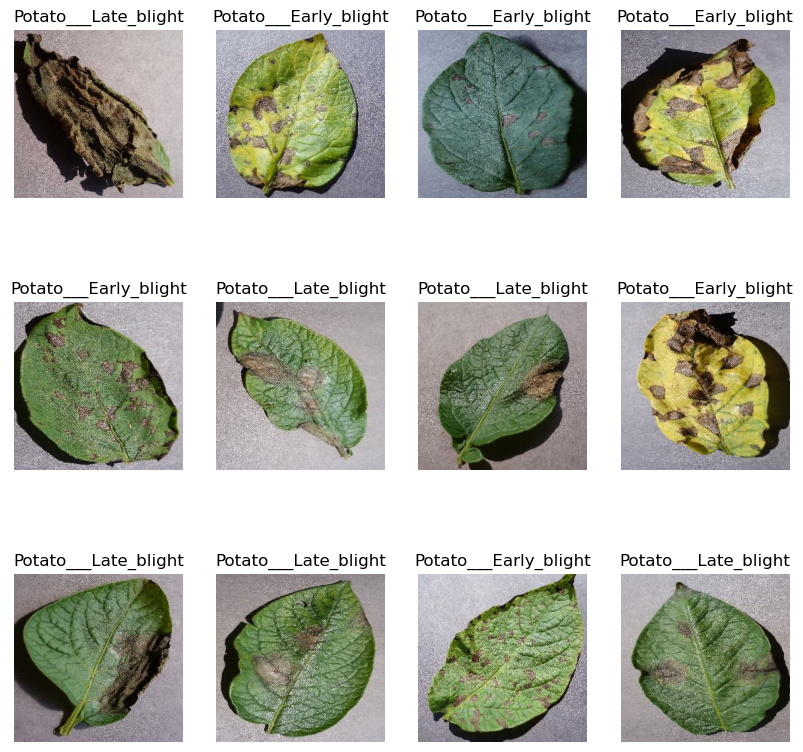

In [10]:
 plt.figure(figsize=(10,10))               #specifying the area for the plot 
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   #batches as numpy array input
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#     print(image_batch[0].numpy()) 
#     print(image_batch[0].shape)

###### SAMPLE DATASET PARTITION CASE

In [11]:
len(dataset)          #no. of batches

68

In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [13]:
train_size=0.8
len(dataset)*train_size       #no. of training dataset batches ~ 54

54.400000000000006

In [14]:
train_Ds=dataset.take(54)   
len(train_Ds)

54

In [15]:
test_Ds=dataset.skip(54) 
len(test_Ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_Ds=test_Ds.take(6)
len(val_Ds)              #no. of validation dataset batches

6

In [18]:
test_Ds=test_Ds.skip(6)
len(test_Ds)              #no. of test dataset batches

8

###### GET DATASET PARTITONS METHOD

In [19]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=15)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_Ds=ds.take(train_size)
    val_Ds=ds.skip(train_size).take(val_size)
    test_Ds=ds.skip(train_size).skip(val_size)
    
    return train_Ds,val_Ds,test_Ds

In [20]:
train_Ds,val_Ds,test_Ds = get_dataset_partitions(dataset)

In [21]:
len(train_Ds)

54

In [22]:
len(val_Ds)

6

In [23]:
len(test_Ds)

8

###### OPTIMIZING THE DATASETS

In [24]:
#optimization of the datasets (reduces training time)
train_Ds=train_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)     
val_Ds=val_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_Ds=test_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

###### RESIZING AND RESCALING LAYER

In [25]:
#scaling from 256 to b/w 0&1
# resizing in case some image of other size is present 
resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_Size,image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

###### DATA AUGMENTATION LAYER

In [26]:
#Data Augmentation
# in case of rotation,different contrast,Zoom,flip etc
#Model will be robust and predict for all the above cases correctly

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

###### CONVOLUTIONAL NEURAL NETWORK MODEL (CNN) 

In [28]:
input_shape=(batch_Size, image_Size, image_Size, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_rescale_layer,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape=input_shape),   #CONVOLUTIONAL LAYER
    layers.MaxPooling2D((2,2)),                                            #Pooling Layer-MaxPooling
    layers.Conv2D(64, (3,3), activation='relu'),   
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),                      #normalizes the probability of your classes
])

model.build(input_shape=input_shape)                   #building the neural network

In [29]:
model.summary()                                      #Defining the neural network architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_Ds,
    epochs=EPOCHS,
    batch_size=batch_Size,
    verbose=1,
    validation_data=val_Ds
)

Epoch 1/50


54/54 [==============================] - 66s 1s/step - loss: 0.8770 - accuracy: 0.5481 - val_loss: 0.7377 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 60s 1s/step - loss: 0.5779 - accuracy: 0.7518 - val_loss: 0.4650 - val_accuracy: 0.8073
Epoch 3/50
54/54 [==============================] - 60s 1s/step - loss: 0.3704 - accuracy: 0.8615 - val_loss: 0.3569 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 59s 1s/step - loss: 0.2314 - accuracy: 0.9137 - val_loss: 0.2098 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 79s 1s/step - loss: 0.2054 - accuracy: 0.9196 - val_loss: 0.2320 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 62s 1s/step - loss: 0.2084 - accuracy: 0.9190 - val_loss: 0.1578 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 63s 1s/step - loss: 0.1526 - accuracy: 0.9425 - val_loss: 0.2335 - val_accuracy: 0.9010
Epoch 8/50
54/54 [

In [32]:
scores = model.evaluate(test_Ds)

8/8 [==============================] - 3s 218ms/step - loss: 0.1365 - accuracy: 0.9453


In [33]:
scores

[0.13652241230010986, 0.9453125]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history.history['accuracy']

[0.5481220483779907,
 0.7517605423927307,
 0.8615023493766785,
 0.9137324094772339,
 0.9196009635925293,
 0.9190140962600708,
 0.9424882531166077,
 0.934272289276123,
 0.95363849401474,
 0.9460093975067139,
 0.9266431927680969,
 0.9454225301742554,
 0.9659624695777893,
 0.9589201807975769,
 0.9683098793029785,
 0.9618544578552246,
 0.9694835543632507,
 0.9771126508712769,
 0.9724178314208984,
 0.952464759349823,
 0.9741784334182739,
 0.9823943376541138,
 0.9659624695777893,
 0.9835680723190308,
 0.9835680723190308,
 0.9823943376541138,
 0.9782863855361938,
 0.9800469279289246,
 0.9876760840415955,
 0.9759389758110046,
 0.9853286147117615,
 0.9829812049865723,
 0.9900234937667847,
 0.9841549396514893,
 0.9865023493766785,
 0.9776995182037354,
 0.9812206625938416,
 0.98591548204422,
 0.9900234937667847,
 0.9847418069839478,
 0.9941314458847046,
 0.9947183132171631,
 0.9906103014945984,
 0.9876760840415955,
 0.9823943376541138,
 0.9853286147117615,
 0.9917840361595154,
 0.9900234937667847

In [38]:
len(history.history['accuracy'])

50

In [39]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

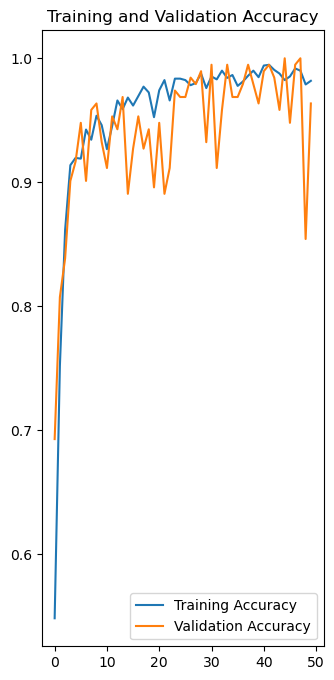

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

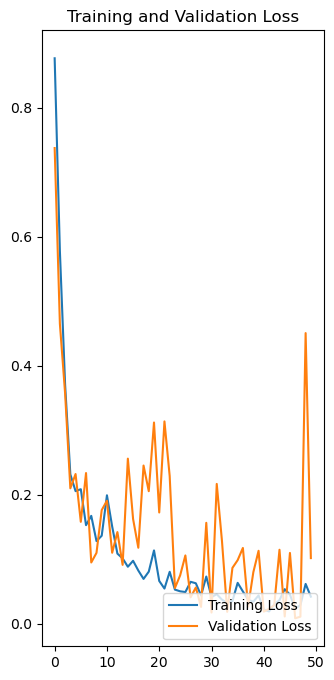

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

In [43]:
import numpy as np

first image to predict
first image actual label: Potato___Early_blight
1/1 [==============================] - 0s 248ms/step
Predicted Label: Potato___Early_blight


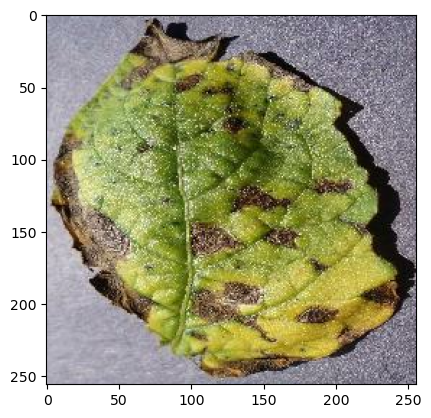

In [45]:
for images_batch,labels_batch in test_Ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0)  #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


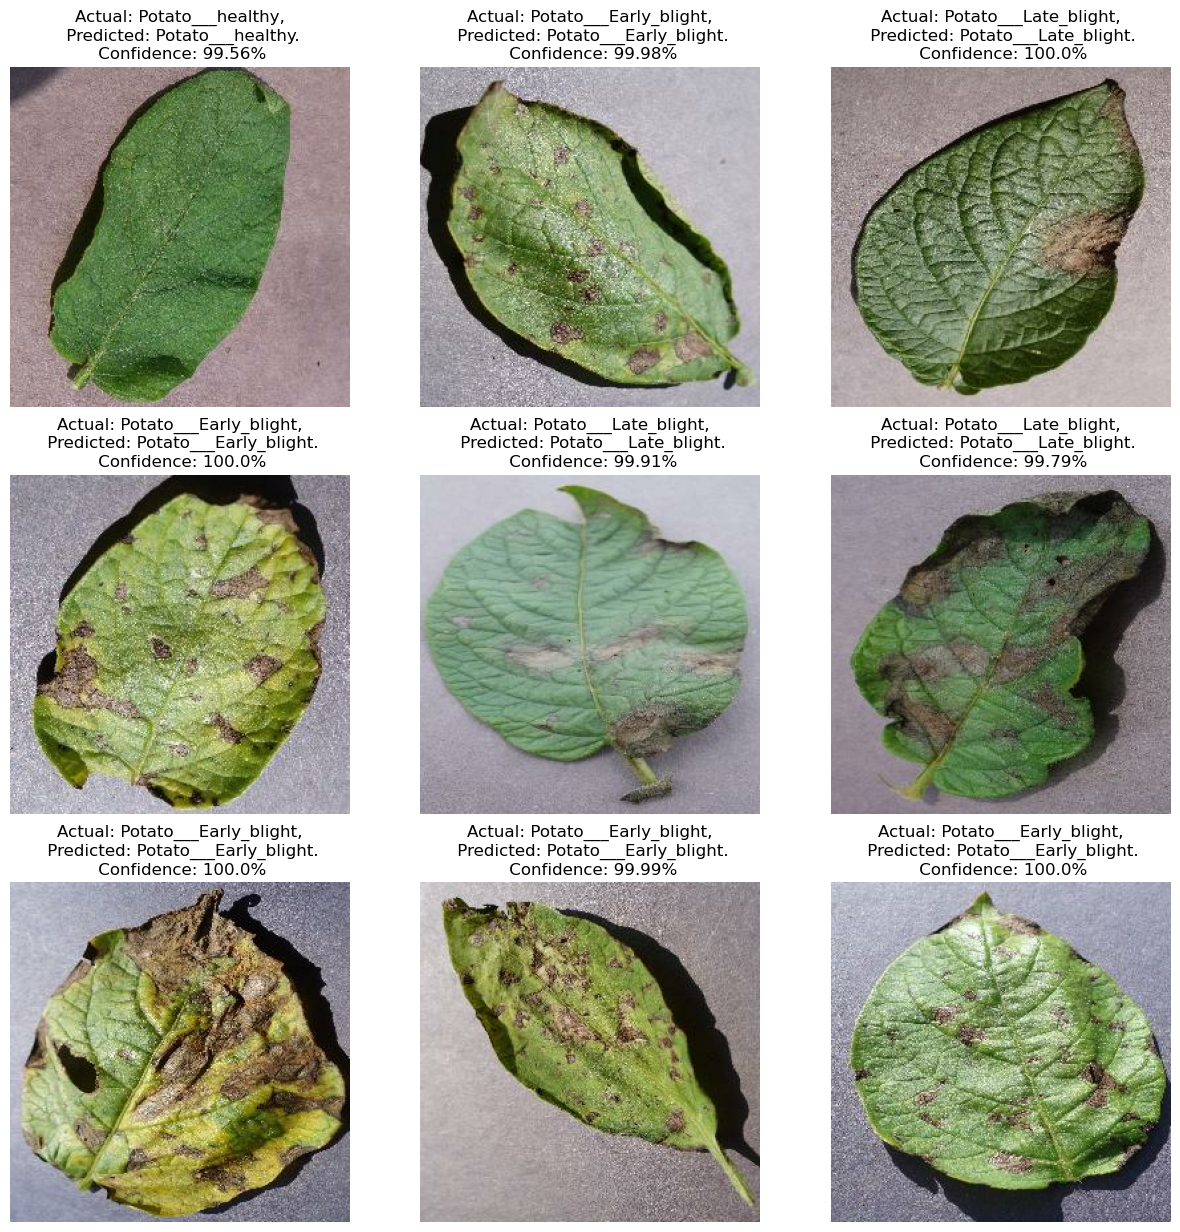

In [47]:
plt.figure(figsize=(15,15))
for images,labels in test_Ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
model_version_=1
model.save(f"../models/{model_version_}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [56]:
import os
os.listdir("../models")

['1']

In [61]:
model_version_=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version_}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
